In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wordle-tweets/tweets.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns
import re

pd.set_option('max_columns', 300)

#For plotting
from itertools import cycle

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# 1. Load the Dataset

In [3]:
tweets = pd.read_csv('/kaggle/input/wordle-tweets/tweets.csv')
tweets.shape
tweets.columns

Index(['wordle_id', 'tweet_id', 'tweet_date', 'tweet_username', 'tweet_text'], dtype='object')

In [4]:
print(tweets['tweet_text'][0])

Wordle 210 4/6

⬛⬛🟨🟨⬛
🟩⬛⬛⬛⬛
🟩🟩🟨⬛⬛
🟩🟩🟩🟩🟩


In [5]:
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩


# 2. Parse Tweets df

In [6]:
# Format datetime in the tweets
def process_tweets(tweets):
    tweets['tweet_datetime']=pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_datetime'].dt.date
    #Extract wordle ID from tweet_text
    tweets['wordle_id']=tweets['tweet_text'].str[:10]
    tweets['n_attempts']=tweets['tweet_text'].str[11].astype('int')
    tweets['id']=tweets['tweet_text'].str[7:10].astype('int')
    return tweets

tweets = process_tweets(tweets)


## How many tweets on wordle each date? 

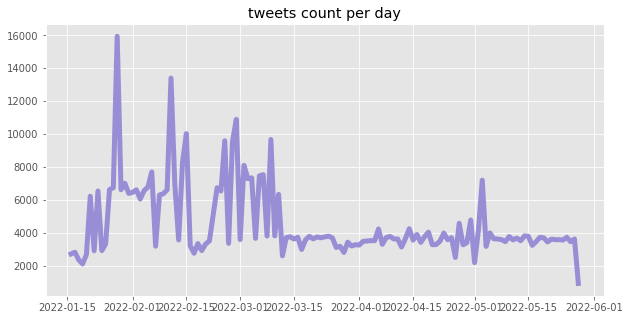

In [7]:
tweets['tweet_date'].value_counts() \
.plot(figsize = (10,5), title = "tweets count per day", color = color_pal[2], lw=5)

plt.show()

## Number of attempts Analysis

In [8]:
tweets.groupby('wordle_id')['n_attempts'].value_counts()\
.unstack() \
.style.background_gradient(axis = 1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


## How many attempts to solve? 

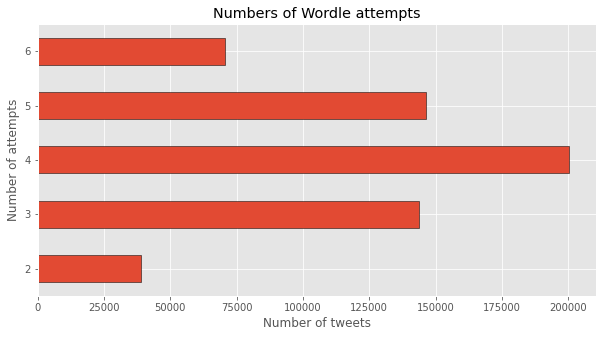

In [9]:
ax = tweets['n_attempts'].value_counts() \
.sort_index() \
.plot(figsize = (10,5), kind = 'barh', title = 'Numbers of Wordle attempts', edgecolor = 'black')

ax.set_ylabel('Number of attempts')
ax.set_xlabel('Number of tweets')
plt.show()

# Parse Tweets text

In [10]:
print(tweets['tweet_text'].values[0])
#Mark dark grid consistent
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

Wordle 210 4/6

⬛⬛🟨🟨⬛
🟩⬛⬛⬛⬛
🟩🟩🟨⬛⬛
🟩🟩🟩🟩🟩


In [11]:
n = 1 # guess number
tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
.str.contains('|'.join(['🟨','⬛','🟩'])) \
.fillna(False)

#tweets['has_guess1'].value_counts()
#Parse out the tweet text
tweets.loc[tweets[f'has_guess{n}'],f'guess{n}'] = \
tweets['tweet_text'].str.split('\n').str[n+1].str[:5]


In [12]:
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_datetime,n_attempts,id,has_guess1,guess1
0,Wordle 210,1482553374591660037,2022-01-16,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:43+00:00,4,210,True,⬛⬛🟨🟨⬛
1,Wordle 210,1482553387937898499,2022-01-16,cruisecoup,Wordle 210 4/6\n\n⬛⬛⬛⬛⬛\n🟩🟩🟨🟨⬛\n🟩🟩⬛🟩🟨\n🟩🟩🟩🟩🟩,2022-01-16 03:20:46+00:00,4,210,True,⬛⬛⬛⬛⬛
2,Wordle 210,1482553422276698113,2022-01-16,DestroVega,Wordle 210 4/6\n\n⬛⬛⬛🟨⬛\n⬛🟩⬛🟨⬛\n⬛🟩⬛🟨⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:55+00:00,4,210,True,⬛⬛⬛🟨⬛
3,Wordle 210,1482553436910628866,2022-01-16,brenmardash,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟨🟨⬛⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:58+00:00,3,210,True,⬛⬛🟨⬛⬛
4,Wordle 210,1482553445726908420,2022-01-16,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:21:00+00:00,3,210,True,⬛⬛🟨⬛⬛


In [13]:
def parse_tweets_text(tweets):
    for n in range(6):
        n += 1 # guess number
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
        .str.contains('|'.join(['🟨','⬛','🟩'])) \
        .fillna(False)

        #tweets['has_guess1'].value_counts()
        #Parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'],f'guess{n}'] = \
        tweets['tweet_text'].str.split('\n').str[n+1].str[:5]

        #Count the incorrect, misplaced and correct
        tweets.loc[tweets[f'has_guess{n}'],f'guess{n}_incorrect']=tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'],f'guess{n}_misplaced']=tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'],f'guess{n}_correct']=tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct']==6 , 'final_guess'] = n
    return tweets

tweets = parse_tweets_text(tweets)
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_datetime,n_attempts,id,has_guess1,guess1,guess1_incorrect,guess1_misplaced,guess1_correct,final_guess,has_guess2,guess2,guess2_incorrect,guess2_misplaced,guess2_correct,has_guess3,guess3,guess3_incorrect,guess3_misplaced,guess3_correct,has_guess4,guess4,guess4_incorrect,guess4_misplaced,guess4_correct,has_guess5,guess5,guess5_incorrect,guess5_misplaced,guess5_correct,has_guess6,guess6,guess6_incorrect,guess6_misplaced,guess6_correct
0,Wordle 210,1482553374591660037,2022-01-16,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:43+00:00,4,210,True,⬛⬛🟨🟨⬛,3,2,0,NaN,True,🟩⬛⬛⬛⬛,4.0,0.0,1.0,True,🟩🟩🟨⬛⬛,2.0,1.0,2.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
1,Wordle 210,1482553387937898499,2022-01-16,cruisecoup,Wordle 210 4/6\n\n⬛⬛⬛⬛⬛\n🟩🟩🟨🟨⬛\n🟩🟩⬛🟩🟨\n🟩🟩🟩🟩🟩,2022-01-16 03:20:46+00:00,4,210,True,⬛⬛⬛⬛⬛,5,0,0,NaN,True,🟩🟩🟨🟨⬛,1.0,2.0,2.0,True,🟩🟩⬛🟩🟨,1.0,1.0,3.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2,Wordle 210,1482553422276698113,2022-01-16,DestroVega,Wordle 210 4/6\n\n⬛⬛⬛🟨⬛\n⬛🟩⬛🟨⬛\n⬛🟩⬛🟨⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:55+00:00,4,210,True,⬛⬛⬛🟨⬛,4,1,0,NaN,True,⬛🟩⬛🟨⬛,3.0,1.0,1.0,True,⬛🟩⬛🟨⬛,3.0,1.0,1.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
3,Wordle 210,1482553436910628866,2022-01-16,brenmardash,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟨🟨⬛⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:58+00:00,3,210,True,⬛⬛🟨⬛⬛,4,1,0,NaN,True,🟨🟨⬛⬛⬛,3.0,2.0,0.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
4,Wordle 210,1482553445726908420,2022-01-16,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:21:00+00:00,3,210,True,⬛⬛🟨⬛⬛,4,1,0,NaN,True,🟩🟩🟩⬛⬛,2.0,0.0,3.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN


In [14]:
#keep additional text
tweets.tail()


,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_datetime,n_attempts,id,has_guess1,guess1,guess1_incorrect,guess1_misplaced,guess1_correct,final_guess,has_guess2,guess2,guess2_incorrect,guess2_misplaced,guess2_correct,has_guess3,guess3,guess3_incorrect,guess3_misplaced,guess3_correct,has_guess4,guess4,guess4_incorrect,guess4_misplaced,guess4_correct,has_guess5,guess5,guess5_incorrect,guess5_misplaced,guess5_correct,has_guess6,guess6,guess6_incorrect,guess6_misplaced,guess6_correct
599936,Wordle 342,1530367096315686914,2022-05-28,UncleBarnack,Wordle 342 3/6\n\n🟨⬛🟨⬛⬛\n⬛🟨🟨🟨⬛\n🟩🟩🟩🟩🟩,2022-05-28 01:55:23+00:00,3,342,True,🟨⬛🟨⬛⬛,3,2,0,NaN,True,⬛🟨🟨🟨⬛,2.0,3.0,0.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
599937,Wordle 342,1530367174560387072,2022-05-28,StillSterling_,Wordle 342 5/6\n\n⬛⬛🟨🟨⬛\n🟨🟨⬛⬛⬛\n⬛🟨🟩⬛⬛\n⬛🟩🟩🟩⬛\n...,2022-05-28 01:55:41+00:00,5,342,True,⬛⬛🟨🟨⬛,3,2,0,NaN,True,🟨🟨⬛⬛⬛,3.0,2.0,0.0,True,⬛🟨🟩⬛⬛,3.0,1.0,1.0,True,⬛🟩🟩🟩⬛,2.0,0.0,3.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN
599938,Wordle 342,1530367185792684033,2022-05-28,jaysmom57,Wordle 342 5/6\n\n⬛⬛⬛🟨🟨\n⬛🟩🟨⬛⬛\n🟩🟩⬛⬛⬛\n🟩🟩⬛⬛⬛\n...,2022-05-28 01:55:44+00:00,5,342,True,⬛⬛⬛🟨🟨,3,2,0,NaN,True,⬛🟩🟨⬛⬛,3.0,1.0,1.0,True,🟩🟩⬛⬛⬛,3.0,0.0,2.0,True,🟩🟩⬛⬛⬛,3.0,0.0,2.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN
599939,Wordle 342,1530367186560118784,2022-05-28,PurpleAries2,Wordle 342 3/6\n\n🟨⬛🟨⬛⬛\n⬛🟨⬛🟩⬛\n🟩🟩🟩🟩🟩,2022-05-28 01:55:44+00:00,3,342,True,🟨⬛🟨⬛⬛,3,2,0,NaN,True,⬛🟨⬛🟩⬛,3.0,1.0,1.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
599940,Wordle 342,1530367229610565633,2022-05-28,cmadmax,Wordle 342 4/6\n\n🟨⬛🟨⬛⬛\n⬛⬛🟩🟨⬛\n⬛⬛🟩🟨🟨\n🟩🟩🟩🟩🟩,2022-05-28 01:55:55+00:00,4,342,True,🟨⬛🟨⬛⬛,3,2,0,NaN,True,⬛⬛🟩🟨⬛,3.0,1.0,1.0,True,⬛⬛🟩🟨🟨,2.0,2.0,1.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN


# Plot the result

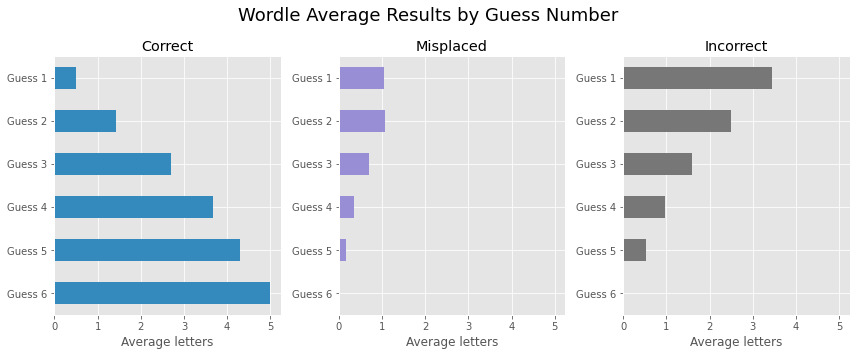

In [15]:
fig,axs = plt.subplots(1,3, figsize = (12,5),sharex = True)

for i,x in enumerate(['_correct','_misplaced','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending = False)\
    .plot(kind = 'barh', title=f'{x.strip("_").replace("_"," ").title()}',ax = axs[i],color = color_pal[i+1])
    axs[i].set_xlabel('Average letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()
